# User defined Functions

In [6]:
def hot_code(df):
    #Re-code effective_to_date
    df.loc[df['effective_to_date'].str.contains("1/"),'effective_to_date']="January"
    df.loc[df['effective_to_date'].str.contains("2/"),'effective_to_date']="February"
    return df

def remove_outliers(df,col_list):
    '''Removes outliers from dataframe DF using the 
    IQR * 1.5 rule.  
    Applies only to the columns in list COL_LIST'''
    
    for i in col_list:
        q1 = df[i].quantile(0.25)
        q3 = df[i].quantile(0.75)

        iqr = q3 - q1

        lower_bound = q1 -(1.5 * iqr) 
        upper_bound = q3 +(1.5 * iqr)


        df.drop(df[ (df[i] > upper_bound) | (df[i] < lower_bound) ].index , inplace=True)
        return(df)

#Get independent variable
def create_y(df,y_name):
    y=df[y_name]
    return y

#get dependent variable
def create_x(df,y_name):
    x=df.drop(labels=y_name,axis=1)
    return x

#Create train-test x,ys
def create_train_test_data(x,y):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.30,random_state=123)
    return x_train,x_test,y_train,y_test

#Create ColumnTransformer to enable transforming of both numerical & categorical data
def col_transformer(x): 

    numerical_columns_selector = selector(dtype_exclude=object)
    categorical_columns_selector = selector(dtype_include=object)

    numerical_columns = numerical_columns_selector(x)
    categorical_columns = categorical_columns_selector(x)


    categorical_preprocessor = OneHotEncoder(drop='first',handle_unknown="ignore")
    numerical_preprocessor = StandardScaler()


    preprocessor = ColumnTransformer([('cat', categorical_preprocessor, categorical_columns),
                                      ('num', numerical_preprocessor, numerical_columns)],sparse_threshold=0)
    return preprocessor


#Run statmodel OLS
def sm_OLS(x_train_scaled,x_test_scaled,y_train):
    x_train_const_scaled = sm.add_constant(x_train_scaled) # adding a constant so that formula understands y=mx+b that b<>0
    model = sm.OLS(y_train, x_train_const_scaled).fit()
    y_pred_train = model.predict(x_train_const_scaled) 

    x_test_const_scaled = sm.add_constant(x_test_scaled) # adding a constant so that formula understands y=mx+b that b<>0
    y_pred_test = model.predict(x_test_const_scaled) 
    return model,y_pred_train,y_pred_test

#Collect results for analysis
def gather_results(model,y_pred_train,y_train):
    m_mse=mse(y_train,y_pred_train)
    rmse=math.sqrt(mse(y_train,y_pred_train))
    r_mae=mae(y_train,y_pred_train)
    r_squared=model.rsquared
    r_squared_adj=model.rsquared_adj
    df_data={'MSE':[round(m_mse,2)],'RMSE':[round(rmse,3)],'R-Squared':[round(r_squared,3)],'R-Squared-Adj':[round(r_squared_adj,3)]}
    temp_df=pd.DataFrame(df_data)
    return temp_df

# Day 1 Import everything

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder  ##. better to use dummy from pandas 
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50
import qgrid
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
import math


In [8]:
df=pd.read_csv(r'C:\Users\MichaelTaylo_c9zoof3\Documents\GitHub\IH_Berliners\Data\5. Updated with continent codes\nutrition_demographic_covid_continent_multicoll_a.csv')

In [41]:

qgrid.show_grid(df,grid_options={'forceFitColumns': False})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

## Check multicollinearity

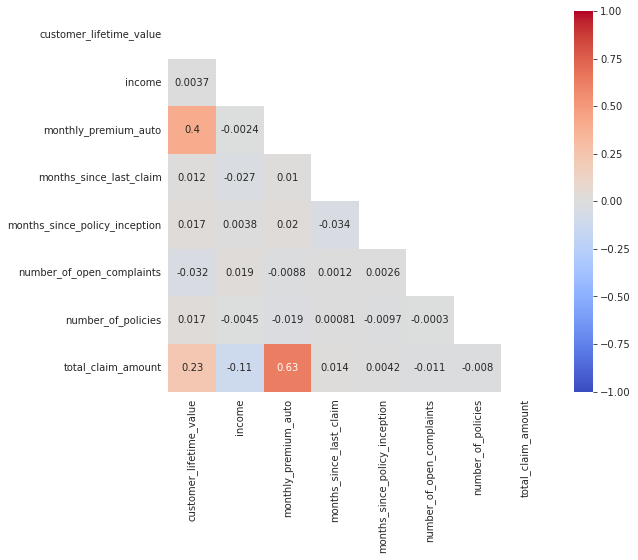

In [42]:
#check if there are highly correlated features and drop them if there are any.
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

## Review numerical data

In [43]:
#get numericals
numericals=df._get_numeric_data()
numericals

#Hotcode date
hot_code(df)

,region,customer_lifetime_value,response,coverage,education,effective_to_date,month,employment_status,gender,income,...,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
0,central,4809,no,basic,college,February,feb,employed,m,48029,...,52,0,9,corporate auto,corporate l3,offer3,agent,292,four-door car,medsize
1,west region,2228,no,basic,college,January,jan,unemployed,f,92260,...,26,0,1,personal auto,personal l3,offer4,call center,744,four-door car,medsize
2,east,14947,no,basic,bachelor,February,feb,employed,m,22139,...,31,0,2,personal auto,personal l3,offer3,call center,480,suv,medsize
3,north west,22332,yes,extended,college,January,jan,employed,m,49078,...,3,0,2,corporate auto,corporate l3,offer2,branch,484,four-door car,medsize
4,north west,9025,no,premium,bachelor,January,jan,medical leave,f,23675,...,31,0,7,personal auto,personal l2,offer1,branch,707,four-door car,medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,central,15563,no,premium,bachelor,January,jan,unemployed,f,61541,...,40,0,7,personal auto,personal l1,offer3,web,1214,luxury car,medsize
10685,north west,5259,no,basic,college,January,jan,employed,f,61146,...,68,0,6,personal auto,personal l3,offer2,branch,273,four-door car,medsize
10686,central,23893,no,extended,bachelor,February,feb,employed,f,39837,...,63,0,2,corporate auto,corporate l3,offer1,web,381,luxury suv,medsize
10687,west region,11971,no,premium,college,February,feb,employed,f,64195,...,27,4,6,personal auto,personal l1,offer1,branch,618,suv,medsize


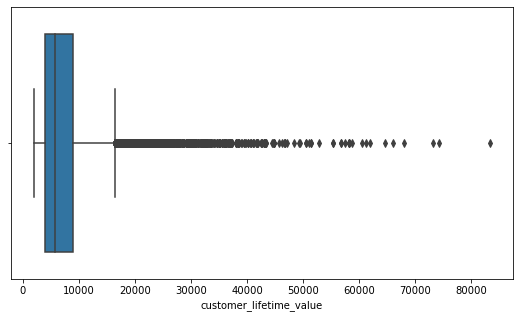

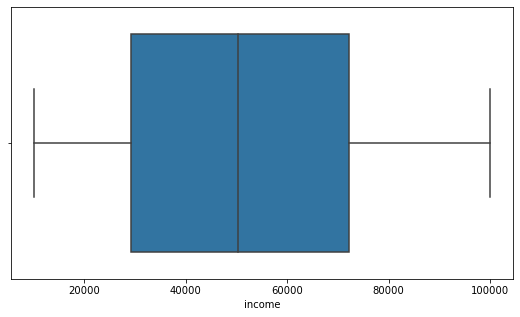

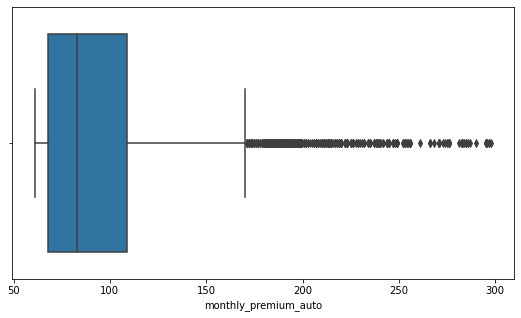

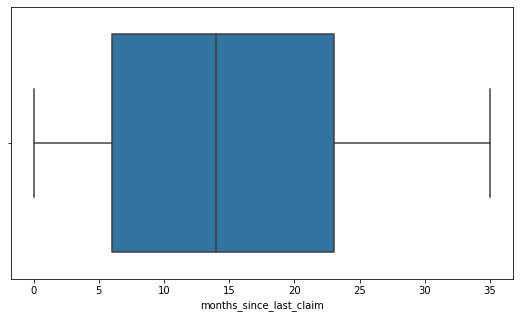

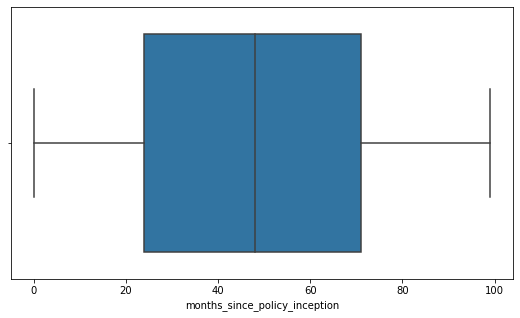

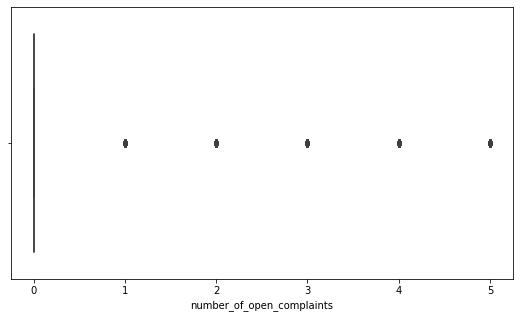

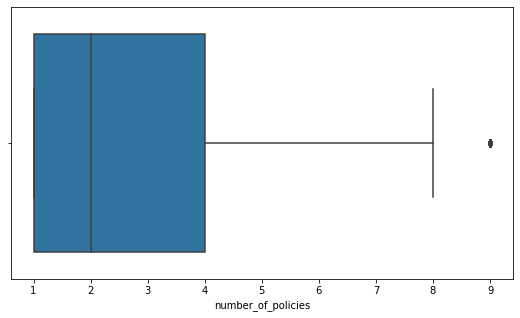

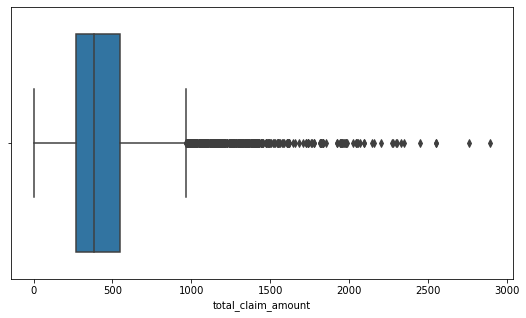

In [44]:
x=numericals.columns
for i in x:
    plt.figure(figsize=(9,5))
    sns.boxplot(x=i,data=numericals) 

array([[<AxesSubplot:title={'center':'customer_lifetime_value'}>,
        <AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'monthly_premium_auto'}>],
       [<AxesSubplot:title={'center':'months_since_last_claim'}>,
        <AxesSubplot:title={'center':'months_since_policy_inception'}>,
        <AxesSubplot:title={'center':'number_of_open_complaints'}>],
       [<AxesSubplot:title={'center':'number_of_policies'}>,
        <AxesSubplot:title={'center':'total_claim_amount'}>,
        <AxesSubplot:>]], dtype=object)

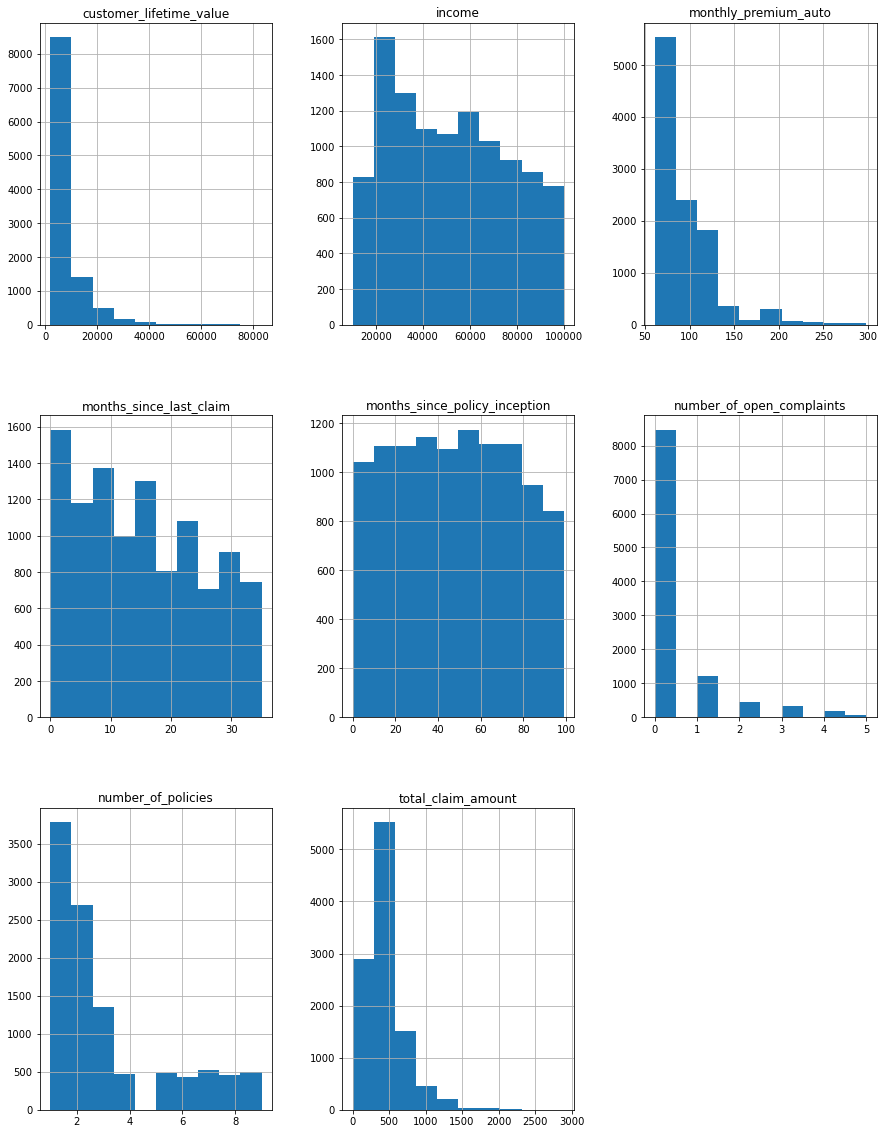

In [45]:
numericals.hist(figsize=(15,20))

# Code used per project

In [46]:
#Which dataframe did I use?

#df_used = numericals.copy()        #numbers only
df_used = df.copy()                #numbers + categorical

## Remove outliers

In [47]:
#Remove outliers
outlier_list=['number_of_policies','customer_lifetime_value','monthly_premium_auto','months since last claim']
remove_outliers(df_used,outlier_list)

,region,customer_lifetime_value,response,coverage,education,effective_to_date,month,employment_status,gender,income,...,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
1,west region,2228,no,basic,college,January,jan,unemployed,f,92260,...,26,0,1,personal auto,personal l3,offer4,call center,744,four-door car,medsize
2,east,14947,no,basic,bachelor,February,feb,employed,m,22139,...,31,0,2,personal auto,personal l3,offer3,call center,480,suv,medsize
3,north west,22332,yes,extended,college,January,jan,employed,m,49078,...,3,0,2,corporate auto,corporate l3,offer2,branch,484,four-door car,medsize
4,north west,9025,no,premium,bachelor,January,jan,medical leave,f,23675,...,31,0,7,personal auto,personal l2,offer1,branch,707,four-door car,medsize
5,west region,4745,yes,basic,high school or below,February,feb,employed,m,50549,...,73,0,7,personal auto,personal l3,offer1,agent,292,four-door car,medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,central,15563,no,premium,bachelor,January,jan,unemployed,f,61541,...,40,0,7,personal auto,personal l1,offer3,web,1214,luxury car,medsize
10685,north west,5259,no,basic,college,January,jan,employed,f,61146,...,68,0,6,personal auto,personal l3,offer2,branch,273,four-door car,medsize
10686,central,23893,no,extended,bachelor,February,feb,employed,f,39837,...,63,0,2,corporate auto,corporate l3,offer1,web,381,luxury suv,medsize
10687,west region,11971,no,premium,college,February,feb,employed,f,64195,...,27,4,6,personal auto,personal l1,offer1,branch,618,suv,medsize


## Start x-y split

In [52]:
#Prep X-Y Split
y_name='total_claim_amount'
y=create_y(df_used,y_name)
x=create_x(df_used,y_name)

#Create train-test data
x_train,x_test,y_train,y_test=create_train_test_data(x,y)

#Create transformer to normalize data
transformer=col_transformer(x_train)

#Normalize/scale data
x_train_scaled=transformer.fit_transform(x_train)
x_test_scaled=transformer.transform(x_test)

feature_names=transformer.get_feature_names_out()
x_train_scaled=pd.DataFrame(data=x_train_scaled,columns=feature_names)
x_test_scaled=pd.DataFrame(data=x_test_scaled,columns=feature_names)

#Create OLS model using statsmodel
y_train=y_train.values.reshape(-1,1)
model,y_pred_train,y_pred_test=sm_OLS(x_train_scaled,x_test_scaled,y_train)

#Gather results of the OLS
#y_pred_test=y_pred_test.values.reshape(-1,1)
results_model=gather_results(model,y_pred_train,y_train)
results_model


,MSE,RMSE,R-Squared,R-Squared-Adj
0,19119.45,138.273,0.778,0.776


In [53]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     505.6
Date:                Fri, 24 Jun 2022   Prob (F-statistic):               0.00
Time:                        09:35:30   Log-Likelihood:                -45307.
No. Observations:                7137   AIC:                         9.071e+04
Df Residuals:                    7087   BIC:                         9.106e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                  135.5415     14.724      9.206      0.000     106.679     164.404
cat__region_east                         4.2000      6.406      0.656      0.512      -8.357      16.757
cat__region_north west                  -1.6645      4.369     -0.381      0.703     -10.228       6.899
cat__region_west region                  2.1707      4.157      0.522      0.602      -5.979      10.320
cat__response_yes                      -19.4119      5.305     -3.659      0.000     -29.812      -9.012
cat__coverage_extended                 -13.4925      4.703     -2.869      0.004     -22.712      -4.273
cat__coverage_premium                   -7.9976      9.160     -0.873      0.383     -25.954       9.959
cat__education_college                  -7.1425      4.310     -1.657      0.098     -15.592       1.307
cat__education_doctor                  -10.6126      9.286     -1.143      0.253     -28.816       7.591
cat__education_high school or below     14.1172      4.316      3.271      0.001       5.656      22.579
cat__education_master                   -9.9323      6.657     -1.492      0.136     -22.983       3.118
cat__effective_to_date_January           0.7345      7.769      0.095      0.925     -14.495      15.964
cat__month_jan                           1.4302      7.675      0.186      0.852     -13.614      16.475
cat__employment_status_employed         -7.6577      8.494     -0.902      0.367     -24.309       8.994
cat__employment_status_medical leave    19.9962     10.911      1.833      0.067      -1.392      41.385
cat__employment_status_retired          -5.9062     12.951     -0.456      0.648     -31.295      19.482
cat__employment_status_unemployed       79.1802      8.962      8.835      0.000      61.611      96.749
cat__gender_m                           16.0166      3.332      4.806      0.000       9.484      22.549
cat__location_code_suburban            375.3663      4.817     77.931      0.000     365.924     384.808
cat__location_code_urban               220.3561      5.430     40.581      0.000     209.711     231.001
cat__marital_status_married             -2.6958      4.868     -0.554      0.580     -12.239       6.847
cat__marital_status_single              67.9599      5.559     12.225      0.000      57.063      78.857
cat__policy_type_personal auto          -9.5296      6.339     -1.503      0.133     -21.957       2.897
cat__policy_type_special auto            2.3401      8.945      0.262      0.794     -15.194      19.874
cat__policy_corporate l2               -20.5023     10.493     -1.954      0.051     -41.072       0.067
cat__policy_corporate l3               -13.2976      9.583     -1.388      0.165     -32.084       5.488
cat__policy_personal l1               

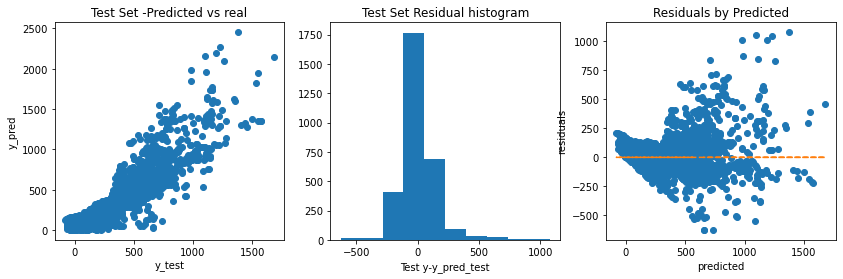

In [54]:
# Make an scatter plot y_pred vs y. Should be close to a straight line
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred_test, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")
# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
y_test.reset_index(drop=True,inplace=True)
ax[1].hist(y_test - y_pred_test)
ax[1].set_xlabel("Test y-y_pred_test")
ax[1].set_title("Test Set Residual histogram")
ax[2].plot(y_pred_test,y_test - y_pred_test,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred_test,np.zeros(len(y_pred_test)),linestyle='dashed')


<AxesSubplot:xlabel='y_pred_test', ylabel='y_test'>

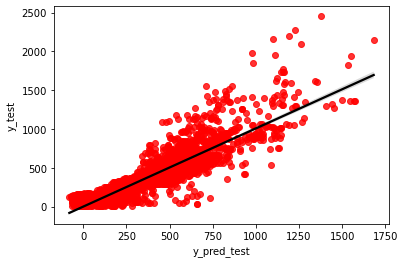

In [55]:
result=pd.DataFrame({"y_test":y_test,"y_pred_test":y_pred_test})

sns.regplot(x='y_pred_test',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

## Coefficients in importance order with p-values

In [56]:
def top_features():
    features_importance = pd.DataFrame(data={
    'Importance': abs(model.params[1:]),
    'Coefficient': model.params[1:], 'P-value': round(model.pvalues[1:],4)})
    features_importance = features_importance.sort_values(by='Importance', ascending=False)
    return features_importance

features_importance=top_features()
qgrid.show_grid(features_importance,grid_options={'forceFitColumns': False})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

# Manual version of stepwise backward elimination

In [57]:
keep_going=True

while keep_going==True:
   #Prep X-Y Split
    y_name='total_claim_amount'
    y=create_y(df_used,y_name)
    x=create_x(df_used,y_name)

    #Create train-test data
    x_train,x_test,y_train,y_test=create_train_test_data(x,y)

    #Create transformer to normalize data
    transformer=col_transformer(x_train)

    #Normalize/scale data
    x_train_scaled=transformer.fit_transform(x_train)
    x_test_scaled=transformer.transform(x_test)
    feature_names=transformer.get_feature_names_out()
    x_train_scaled=pd.DataFrame(data=x_train_scaled,columns=feature_names)
    x_test_scaled=pd.DataFrame(data=x_test_scaled,columns=feature_names)

    #Create OLS model using statsmodel
    y_train=y_train.values.reshape(-1,1)
    model,y_pred_train,y_pred_test=sm_OLS(x_train_scaled,x_test_scaled,y_train)

    #Gather results of the OLS
    #y_pred_test=y_pred_test.values.reshape(-1,1)
    results_model=gather_results(model,y_pred_train,y_train)
    print(results_model)
    
    #remove stepwise feature.  if done is written, stop removing
    features_importance=top_features()
    temp_features=features_importance.sort_values(by='P-value', ascending=False)
    print(temp_features.iloc[0,:])
    drop_value=input("What column to drop?")
    if drop_value=="done":
        keep_going=False
    else:
        df_used.drop(labels=drop_value,axis=1,inplace=True)
        df_used.columns

        MSE     RMSE  R-Squared  R-Squared-Adj
0  19119.45  138.273      0.778          0.776
Importance     0.734476
Coefficient    0.734476
P-value        0.924700
Name: cat__effective_to_date_January, dtype: float64
What column to drop?effective_to_date
        MSE     RMSE  R-Squared  R-Squared-Adj
0  19119.47  138.273      0.778          0.776
Importance     0.547496
Coefficient   -0.547496
P-value        0.905900
Name: cat__sales_channel_call center, dtype: float64
What column to drop?sales_channel
        MSE     RMSE  R-Squared  R-Squared-Adj
0  19120.97  138.279      0.778          0.776
Importance     1.452034
Coefficient    1.452034
P-value        0.819700
Name: cat__vehicle_size_small, dtype: float64
What column to drop?vehicle_size
        MSE     RMSE  R-Squared  R-Squared-Adj
0  19127.32  138.302      0.777          0.776
Importance     1.051988
Coefficient    1.051988
P-value        0.794900
Name: cat__policy_personal l1, dtype: float64
What column to drop?policy
      

In [58]:
def top_features():
    features_importance = pd.DataFrame(data={
    'Importance': abs(model.params[1:]),
    'Coefficient': model.params[1:], 'P-value': round(model.pvalues[1:],4)})
    features_importance = features_importance.sort_values(by='Importance', ascending=False)
    return features_importance

features_importance=top_features()
qgrid.show_grid(features_importance,grid_options={'forceFitColumns': False})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [59]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     3423.
Date:                Fri, 24 Jun 2022   Prob (F-statistic):               0.00
Time:                        09:37:05   Log-Likelihood:                -45832.
No. Observations:                7137   AIC:                         9.168e+04
Df Residuals:                    7130   BIC:                         9.173e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          124.4314      4.296     28.962      0.000     116.009     132.854
cat__response_yes              -37.0946      5.321     -6.971      0.000     -47.526     -26.663
cat__gender_m                   17.4545      3.544      4.925      0.000      10.507      24.402
cat__location_code_suburban    423.8841      4.624     91.664      0.000     414.819     432.949
cat__location_code_urban       219.2403      5.808     37.748      0.000     207.855     230.626
num__monthly_premium_auto      175.8327      1.769     99.411      0.000     172.365     179.300
num__months_since_last_claim     5.8640      1.764      3.325      0.001       2.406       9.322
==============================================================================
Omnibus:                     3673.976   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            48085.107
Skew:                           2.157   Prob(JB):                         0.00
Kurtosis:                      14.962   Cond. No.                         5.72
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

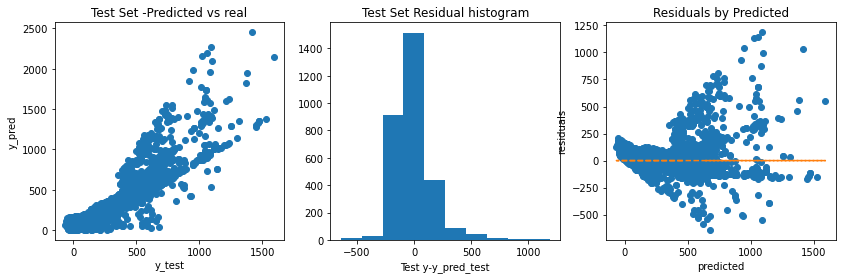

In [60]:
# Make an scatter plot y_pred vs y. Should be close to a straight line
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred_test, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")
# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
y_test.reset_index(drop=True,inplace=True)
ax[1].hist(y_test - y_pred_test)
ax[1].set_xlabel("Test y-y_pred_test")
ax[1].set_title("Test Set Residual histogram")
ax[2].plot(y_pred_test,y_test - y_pred_test,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred_test,np.zeros(len(y_pred_test)),linestyle='dashed')


<AxesSubplot:xlabel='y_pred_test', ylabel='y_test'>

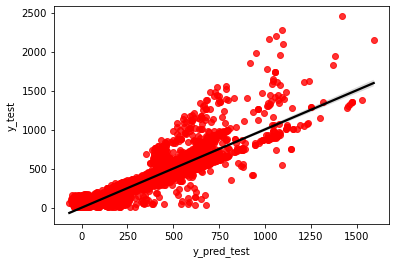

In [61]:
result=pd.DataFrame({"y_test":y_test,"y_pred_test":y_pred_test})

sns.regplot(x='y_pred_test',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})